### Face Recognition Via SVM and Feature Extraction  Via PCA

In [100]:
import numpy as np
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt

#### Load Labeled Faces in the Wild
This dataset is a collection of JPEG pictures of famous people
collected on the internet, all details are available on the
official website:

    http://vis-www.cs.umass.edu/lfw/

In [101]:
lfw_people = fetch_lfw_people(min_faces_per_person=70)
lfw_people

{'DESCR': 'LFW faces dataset',
 'data': array([[253.66667 , 254.33333 , 253.66667 , ...,  87.      ,  88.      ,
          86.666664],
        [ 38.333332,  43.      ,  53.      , ..., 114.666664, 116.666664,
         143.66667 ],
        [ 88.      ,  92.666664, 112.666664, ..., 182.66667 , 183.66667 ,
         182.66667 ],
        ...,
        [ 86.333336,  83.333336,  76.333336, ...,  48.      ,  49.      ,
          40.666668],
        [ 49.333332,  55.666668,  76.666664, ..., 186.33333 , 176.33333 ,
         161.      ],
        [ 31.      ,  26.333334,  28.      , ...,  34.      ,  42.      ,
          69.666664]], dtype=float32),
 'images': array([[[253.66667 , 254.33333 , 253.66667 , ...,  56.333332,
           46.666668,  39.      ],
         [254.      , 254.      , 253.      , ...,  58.      ,
           48.333332,  40.666668],
         [250.      , 247.      , 243.33333 , ...,  56.666668,
           48.333332,  42.333332],
         ...,
         [ 73.333336,  58.      ,  39

In [102]:
lfw_people.data.shape

(1288, 2914)

In [103]:
lfw_people.target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [104]:
lfw_people.images.shape

(1288, 62, 47)

In [105]:
x = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

n_samples, n_features = x.shape
_, h, w = lfw_people.images.shape
n_classes = len(lfw_people.target_names)

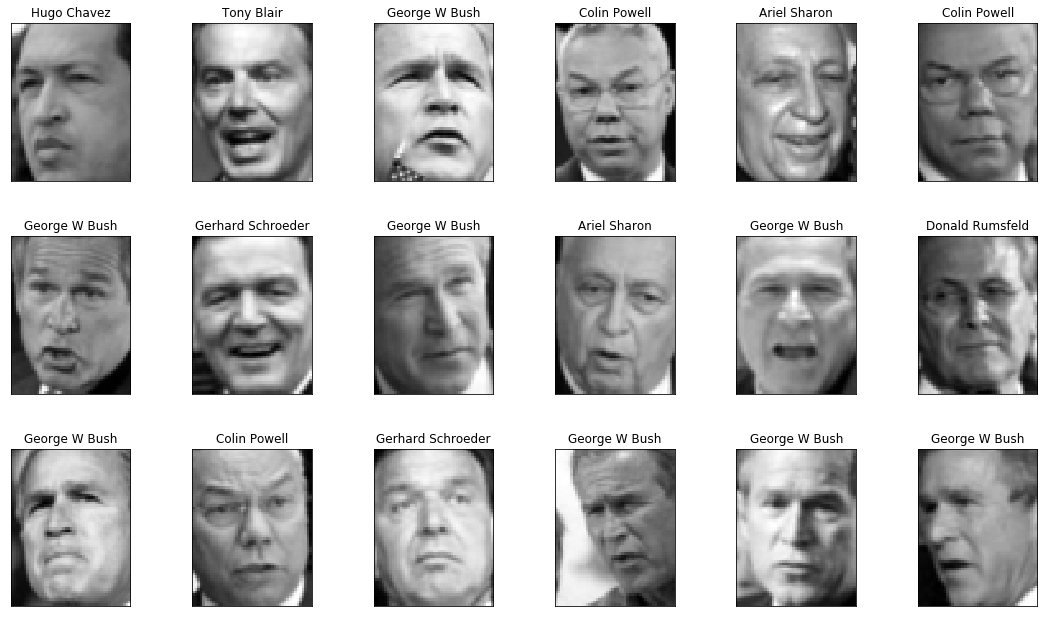

In [106]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(2.5 * n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(x, names[y], h, w)

<BarContainer object of 7 artists>

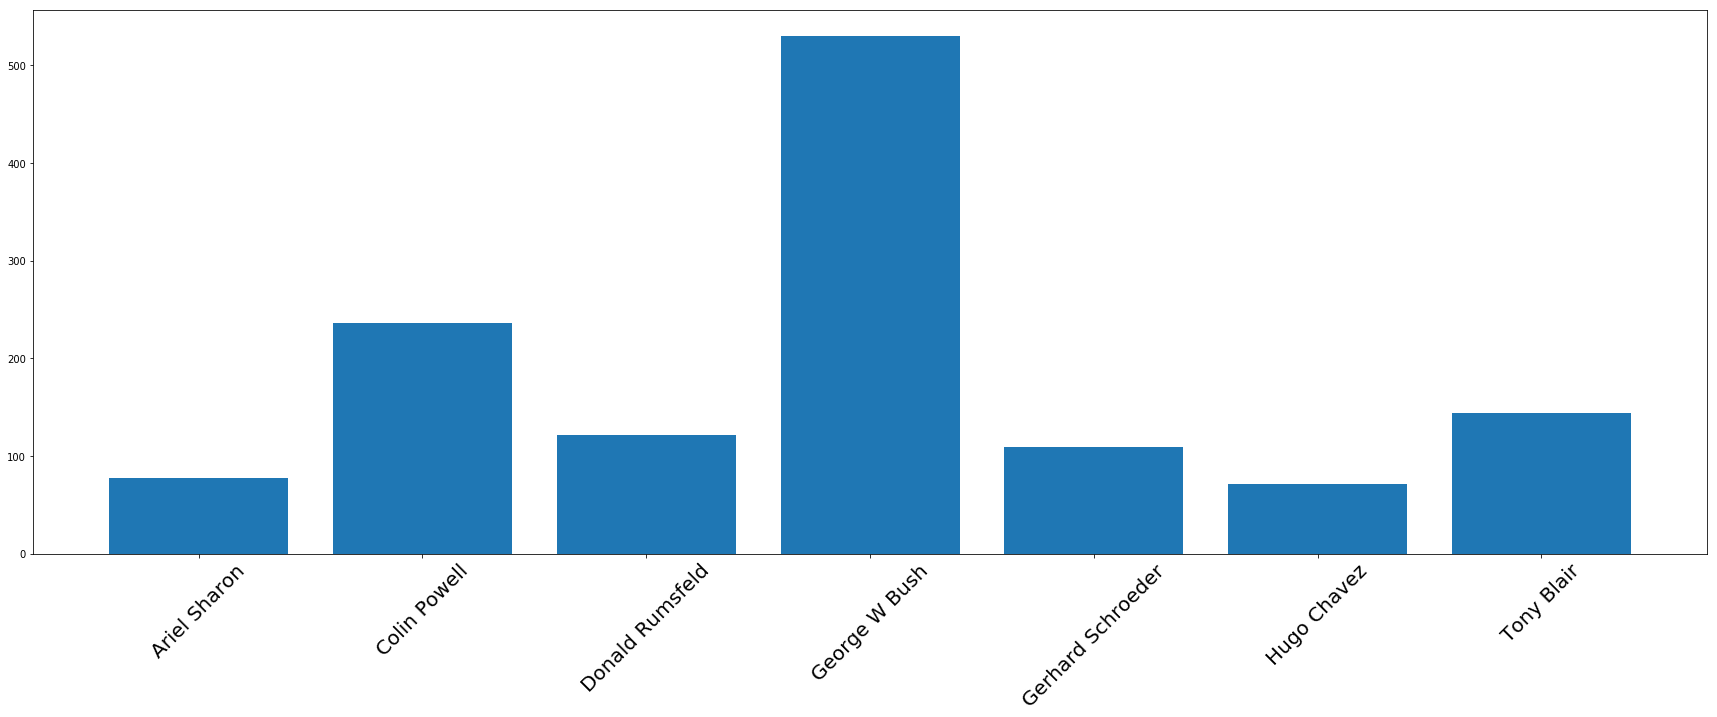

In [107]:
plt.figure(figsize=(30, 10))

y_unique = np.unique(y)
counts = [(y == i).sum() for i in y_unique]

plt.xticks(y_unique, names[y_unique])
locs, labels = plt.xticks()
plt.setp(labels, rotation=45, size=20)
plt.bar(y_unique, counts)

### Splitting the Dataset for Trainset and Testset

In [108]:
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
x_train.shape

(966, 2914)

In [110]:
from sklearn.decomposition import PCA

n_components = 120

print ("Extracting the top %d eigenfaces from %d faces" % (
    n_components, x_train.shape[0]))

pca = PCA(n_components=n_components, whiten=True, svd_solver='randomized')

%time pca.fit(x_train)

eigenfaces = pca.components_.reshape((n_components, h, w))
pca.components_.shape

Extracting the top 120 eigenfaces from 966 faces
CPU times: user 259 ms, sys: 17 µs, total: 259 ms
Wall time: 138 ms


(120, 2914)

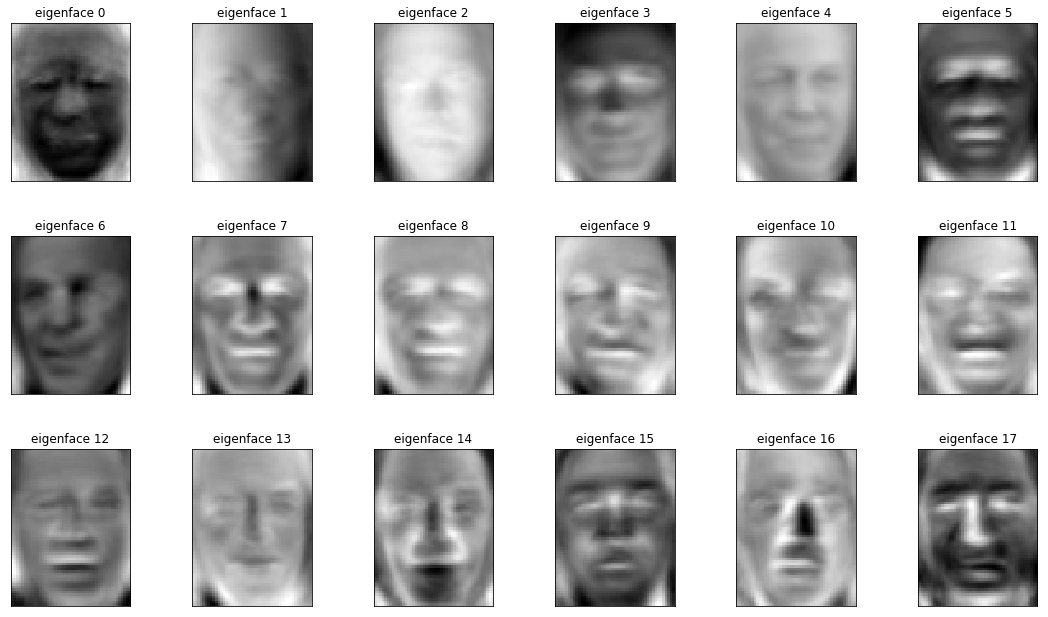

In [95]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

#### 将数据投影到新的特征空间

In [96]:
x_train_pca = pca.transform(x_train)

In [97]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)

clf.fit(x_train_pca, y_train)
clf.best_estimator_

SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

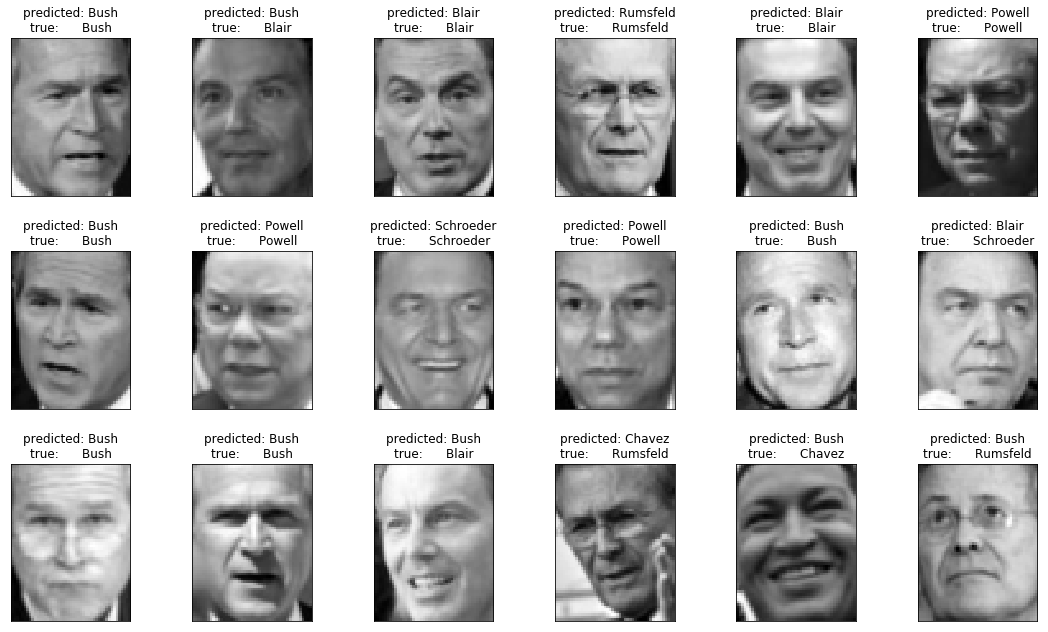

In [98]:
y_pred = clf.best_estimator_.predict(pca.transform(x_test))
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(x_test, prediction_titles, h, w)

In [99]:
from sklearn.metrics import classification_report
 
print(classification_report(y_test, y_pred, target_names=names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.92      0.86      0.89        14
     Colin Powell       0.78      0.90      0.83        50
  Donald Rumsfeld       0.90      0.69      0.78        39
    George W Bush       0.88      0.95      0.91       136
Gerhard Schroeder       0.89      0.83      0.86        29
      Hugo Chavez       0.78      0.78      0.78         9
       Tony Blair       0.92      0.80      0.86        45

      avg / total       0.87      0.87      0.87       322

